# Models Comparison for TinyML

In [25]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [26]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [27]:
data = ['../data/X-intensity.pkl', '../data/X-all.pkl', '../data/X-10-25.pkl', '../data/X-1-2.pkl', '../data/X-25_50-50_25.pkl']
labels = ['../data/y-intensity.pkl', '../data/y-all.pkl', '../data/y-10-25.pkl', '../data/y-1-2.pkl', '../data/y-25_50-50_25.pkl']
choosenIndex = 1
tasks = ['intensity', 'all','10-25','1-2', '25-50']
with open(data[choosenIndex], 'rb') as f:
    X = pickle.load(f)

with open(labels[choosenIndex], 'rb') as f:
    y = pickle.load(f)

In [28]:
if choosenIndex == 1:
    X = X[165:-13]
    y = y[165:-13]
if choosenIndex == 2:
    X = X[146:-13]
    y = y[146:-13]
if choosenIndex == 3:
    X = X[101:-13]
    y = y[101:-13]

In [29]:
print(X.shape)

(8329, 60)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
uniques = np.unique(y)

In [41]:
y_test = y_test[:half]
print(y_test)

[5 3 0 3 0 4 0 5 3 1 2 0 5 1 0 1 5 1 0 2 5 5 5 5 5 3 2 0 4 0 0 1 3 2 4 2 2
 3 5 3 1 1 3 5 3 3 5 5 1 3 5 0 2 2 3 3 1 0 4 0 0 0 1 0 5 4 0 0 1 4 0 3 3 4
 5 4 3 0 4 5 0 3 0 1 0 1 1 0 4 2 0 5 4 3 2 3 4 0 0 0 3 1 2 0 2 0 4 5 4 3 2
 5 3 1 4 2 3 0 1 1 5 5 5 1 3 2 4 3 5 4 2 2 2 3 4 0 5 0 5 4 3 3 3 1 0 5 1 4
 2 5 1 3 1 3 4 1 0 0 3 5 5 4 4 1 0 1 5 4 2 3 5 2 2 5 2 1 5 5 3 1 3 1 0 5 5
 4 0 1 3 0 2 2 1 5 3 2 3 4 3 3 3 5 3 2 4 0 1 3 1 0 4 0 4 5 5 1 2 5 3 2 1 0
 2 3 3 3 2 5 4 0 2 5 4 1 2 3 5 1 4 1 3 3 3 1 3 5 4 4 0 4 2 1 4 1 2 4 3 5 4
 4 3 3 4 0 3 4 1 5 2 4 4 0 3 4 3 2 5 3 5 5 2 2 0 3 2 3 3 1 2 3 5 0 0 3 1 2
 4 5 1 5 1 3 5 0 3 2 1 2 5 5 2 5 3 2 4 4 1 5 3 5 5 0 3 2 4 2 4 4 3 1 4 2 3
 0 5 1 2 5 1 3 4 4 5 1 2 4 2 5 3 2 5 1 5 3 5 4 5 5 1 0 0 3 5 2 5 0 0 0 3 0
 1 3 5 1 4 5 4 1 3 4 4 4 5 2 3 4 4 4 3 5 4 2 5 2 2 3 3 3 4 1 2 4 1 4 5 2 0
 0 3 4 5 0 1 5 5 1 5 1 5 2 5 4 2 1 4 3 1 3 2 3 3 5 1 5 1 5 1 5 1 5 3 1 0 1
 5 3 1 3 3 2 5 5 3 4 5 3 0 2 0 1 0 0 5 3 2 1 1 5 4 4 1 0 5 2 0 4 2 1 4 3 5
 0 1 4 2 1 1 1 5 3 2 1 2 

In [31]:
#Altrimenti il testSet viene troppo lungo e impossibile da caricare
if choosenIndex == 1:
    half = X_test.shape[0] // 2
    X_test = X_test[:half, :]
    y_test = y_test[:half]
print(X_test.shape)
print(X_test)

(833, 60)
[[ 0.03  0.02  0.99 -0.03 -0.01  0.96 -0.   -0.01  0.96  0.05  0.01  1.
   0.02  0.03  1.03 -0.01 -0.02  0.96  0.02  0.    0.98  0.02  0.01  0.98
   0.04 -0.02  0.92  0.07  0.02  1.01  0.08  0.02  0.97 -0.03 -0.01  0.97
   0.08 -0.    0.9   0.04  0.02  1.01  0.02  0.01  0.98  0.02  0.01  0.99
   0.09  0.01  0.94  0.08  0.01  0.96  0.02  0.01  1.01  0.1   0.03  0.99]
 [ 0.03  0.11  0.97  0.02  0.11  1.    0.01  0.09  1.01  0.02  0.08  1.04
  -0.04  0.06  0.98 -0.04  0.11  0.94 -0.    0.11  1.02 -0.08  0.04  0.99
  -0.03  0.07  0.98  0.05  0.15  0.99 -0.    0.09  1.01  0.04  0.13  1.03
  -0.03  0.07  0.99 -0.07  0.05  0.96  0.    0.08  0.96  0.03  0.14  0.96
   0.03  0.12  0.96  0.02  0.06  1.01 -0.02  0.09  0.98  0.01  0.13  0.99]
 [-0.03  0.02  0.98 -0.05  0.03  0.98 -0.03  0.03  0.98 -0.05  0.02  0.98
  -0.03  0.04  0.98 -0.04  0.02  0.98 -0.04  0.04  0.99 -0.04  0.01  0.98
  -0.05  0.04  0.98 -0.04  0.01  0.98 -0.05  0.04  0.98 -0.03  0.01  0.98
  -0.05  0.04  0.98 -0.03  0

## Model Spotting

In [42]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [43]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR',  LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [44]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 1,00 0,00
LR - 0,98 0,00
CART - 0,97 0,01
SVC - 0,99 0,00
RF - 1,00 0,00


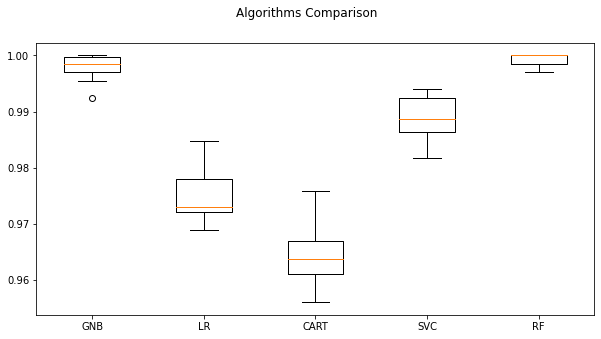

In [45]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Valutazione dei modelli sul Test Set

In [49]:

def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = uniques[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex]+ '/classificationReports'+ '/'+'classification_report' + model_name +  '.csv', index = False)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      1.00      1.00       282
           2       1.00      1.00      1.00       213
           3       1.00      1.00      1.00       291
           4       1.00      1.00      1.00       282
           5       1.00      1.00      1.00       357

    accuracy                           1.00      1666
   macro avg       1.00      1.00      1.00      1666
weighted avg       1.00      1.00      1.00      1666



IndexError: list index out of range

# Neural Network

In [47]:
def getNetwork():
    n = 50
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [148]:
EPOCHS = 100
BATCH_SIZE = 10
num_folds = 10

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_43 (Dense)             (None, 250)               15250     
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 1255      
Total params: 20,165
Trainable params: 20,165
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
281/281 [==============================] - 0s 519us/step - loss: 1.6089 - accuracy: 0.2176
Epoch 2/100
281/281 [==============================] - 0s 557us/step - loss: 1.5890 - accuracy: 0.3020
Epoch 3/100
281/281 [==============================] - 0s 531us/step - loss: 1.5633 - accuracy: 0.3590
Epoch 4/100
281/281 [==============================] - 0s 511us/step -

281/281 [==============================] - 0s 605us/step - loss: 0.5933 - accuracy: 0.8027
Epoch 44/100
281/281 [==============================] - 0s 617us/step - loss: 0.5830 - accuracy: 0.8073
Epoch 45/100
281/281 [==============================] - 0s 600us/step - loss: 0.5739 - accuracy: 0.8141
Epoch 46/100
281/281 [==============================] - 0s 598us/step - loss: 0.5647 - accuracy: 0.8180
Epoch 47/100
281/281 [==============================] - 0s 590us/step - loss: 0.5580 - accuracy: 0.8234
Epoch 48/100
281/281 [==============================] - 0s 564us/step - loss: 0.5454 - accuracy: 0.8152
Epoch 49/100
281/281 [==============================] - 0s 568us/step - loss: 0.5382 - accuracy: 0.8291
Epoch 50/100
281/281 [==============================] - 0s 534us/step - loss: 0.5294 - accuracy: 0.8298
Epoch 51/100
281/281 [==============================] - 0s 643us/step - loss: 0.5231 - accuracy: 0.8344
Epoch 52/100
281/281 [==============================] - 0s 563us/step - loss:

281/281 [==============================] - 0s 474us/step - loss: 0.2595 - accuracy: 0.9199
Epoch 93/100
281/281 [==============================] - 0s 479us/step - loss: 0.2563 - accuracy: 0.9252
Epoch 94/100
281/281 [==============================] - 0s 484us/step - loss: 0.2533 - accuracy: 0.9241
Epoch 95/100
281/281 [==============================] - 0s 467us/step - loss: 0.2496 - accuracy: 0.9249
Epoch 96/100
281/281 [==============================] - 0s 475us/step - loss: 0.2467 - accuracy: 0.9249
Epoch 97/100
281/281 [==============================] - 0s 472us/step - loss: 0.2457 - accuracy: 0.9231
Epoch 98/100
281/281 [==============================] - 0s 462us/step - loss: 0.2422 - accuracy: 0.9259
Epoch 99/100
281/281 [==============================] - 0s 480us/step - loss: 0.2402 - accuracy: 0.9274
Epoch 100/100
281/281 [==============================] - 0s 472us/step - loss: 0.2362 - accuracy: 0.9284
Model: "Sequential-NN"
_____________________________________________________

281/281 [==============================] - 0s 515us/step - loss: 0.6529 - accuracy: 0.7877
Epoch 35/100
281/281 [==============================] - 0s 474us/step - loss: 0.6386 - accuracy: 0.7959
Epoch 36/100
281/281 [==============================] - 0s 481us/step - loss: 0.6239 - accuracy: 0.8020
Epoch 37/100
281/281 [==============================] - 0s 474us/step - loss: 0.6115 - accuracy: 0.8070
Epoch 38/100
281/281 [==============================] - 0s 491us/step - loss: 0.5990 - accuracy: 0.8116
Epoch 39/100
281/281 [==============================] - 0s 471us/step - loss: 0.5883 - accuracy: 0.8180
Epoch 40/100
281/281 [==============================] - 0s 464us/step - loss: 0.5771 - accuracy: 0.8162
Epoch 41/100
281/281 [==============================] - 0s 459us/step - loss: 0.5641 - accuracy: 0.8248
Epoch 42/100
281/281 [==============================] - 0s 460us/step - loss: 0.5530 - accuracy: 0.8291
Epoch 43/100
281/281 [==============================] - 0s 495us/step - loss:

Epoch 84/100
281/281 [==============================] - 0s 484us/step - loss: 0.2135 - accuracy: 0.9241
Epoch 85/100
281/281 [==============================] - 0s 483us/step - loss: 0.2104 - accuracy: 0.9298
Epoch 86/100
281/281 [==============================] - 0s 458us/step - loss: 0.2078 - accuracy: 0.9266
Epoch 87/100
281/281 [==============================] - 0s 485us/step - loss: 0.2029 - accuracy: 0.9323
Epoch 88/100
281/281 [==============================] - 0s 472us/step - loss: 0.2005 - accuracy: 0.9327
Epoch 89/100
281/281 [==============================] - 0s 462us/step - loss: 0.1970 - accuracy: 0.9380
Epoch 90/100
281/281 [==============================] - 0s 471us/step - loss: 0.1960 - accuracy: 0.9366
Epoch 91/100
281/281 [==============================] - 0s 474us/step - loss: 0.1923 - accuracy: 0.9323
Epoch 92/100
281/281 [==============================] - 0s 480us/step - loss: 0.1899 - accuracy: 0.9363
Epoch 93/100
281/281 [==============================] - 0s 492us

281/281 [==============================] - 0s 499us/step - loss: 0.6482 - accuracy: 0.8170
Epoch 27/100
281/281 [==============================] - 0s 484us/step - loss: 0.6276 - accuracy: 0.8198
Epoch 28/100
281/281 [==============================] - 0s 626us/step - loss: 0.6048 - accuracy: 0.8319
Epoch 29/100
281/281 [==============================] - 0s 507us/step - loss: 0.5858 - accuracy: 0.8362
Epoch 30/100
281/281 [==============================] - 0s 497us/step - loss: 0.5664 - accuracy: 0.8426
Epoch 31/100
281/281 [==============================] - 0s 521us/step - loss: 0.5477 - accuracy: 0.8458
Epoch 32/100
281/281 [==============================] - 0s 488us/step - loss: 0.5309 - accuracy: 0.8536
Epoch 33/100
281/281 [==============================] - 0s 503us/step - loss: 0.5137 - accuracy: 0.8558
Epoch 34/100
281/281 [==============================] - 0s 475us/step - loss: 0.4989 - accuracy: 0.8579
Epoch 35/100
281/281 [==============================] - 0s 491us/step - loss:

281/281 [==============================] - 0s 471us/step - loss: 1.5995 - accuracy: 0.2464
Epoch 2/100
281/281 [==============================] - 0s 491us/step - loss: 1.5685 - accuracy: 0.3725
Epoch 3/100
281/281 [==============================] - 0s 477us/step - loss: 1.5252 - accuracy: 0.4099
Epoch 4/100
281/281 [==============================] - 0s 503us/step - loss: 1.4619 - accuracy: 0.4366
Epoch 5/100
281/281 [==============================] - 0s 507us/step - loss: 1.3845 - accuracy: 0.4726
Epoch 6/100
281/281 [==============================] - 0s 506us/step - loss: 1.3065 - accuracy: 0.5071
Epoch 7/100
281/281 [==============================] - 0s 518us/step - loss: 1.2383 - accuracy: 0.5477
Epoch 8/100
281/281 [==============================] - 0s 499us/step - loss: 1.1846 - accuracy: 0.5734
Epoch 9/100
281/281 [==============================] - 0s 461us/step - loss: 1.1412 - accuracy: 0.5969
Epoch 10/100
281/281 [==============================] - 0s 472us/step - loss: 1.1065 

Epoch 80/100
281/281 [==============================] - 0s 457us/step - loss: 0.2285 - accuracy: 0.9313
Epoch 81/100
281/281 [==============================] - 0s 460us/step - loss: 0.2226 - accuracy: 0.9363
Epoch 82/100
281/281 [==============================] - 0s 463us/step - loss: 0.2197 - accuracy: 0.9330
Epoch 83/100
281/281 [==============================] - 0s 484us/step - loss: 0.2146 - accuracy: 0.9373
Epoch 84/100
281/281 [==============================] - 0s 481us/step - loss: 0.2116 - accuracy: 0.9359
Epoch 85/100
281/281 [==============================] - 0s 461us/step - loss: 0.2082 - accuracy: 0.9377
Epoch 86/100
281/281 [==============================] - 0s 517us/step - loss: 0.2041 - accuracy: 0.9352
Epoch 87/100
281/281 [==============================] - 0s 474us/step - loss: 0.2007 - accuracy: 0.9377
Epoch 88/100
281/281 [==============================] - 0s 467us/step - loss: 0.1985 - accuracy: 0.9420
Epoch 89/100
281/281 [==============================] - 0s 460us

# Train and Test

In [48]:
EPOCHS = 100
BATCH_SIZE = 10
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
report = classification_report(y_test, pred)
classification_report_csv(report, "NN")
print(report)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_7 (Dense)              (None, 300)               18300     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 1806      
Total params: 23,766
Trainable params: 23,766
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
500/500 [==============================] - 0s 861us/step - loss: 1.6702 - accuracy: 0.3916 - val_loss: 1.4755 - val_accuracy: 0.5672
Epoch 2/100
500/500 [==============================] - 0s 761us/step - loss: 1.1903 - accuracy: 0.6270 - val_loss: 0.9119 - val_accuracy: 0.7095
Epoch 3/100
385/500 [======================>.......] - ETA: 0s - loss: 0.7805 - accuracy:

KeyboardInterrupt: 

# Export Models in C code

In [38]:
# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    with open(path, 'w') as f:
        f.write(port(model, optimize=False))

INFO:tensorflow:Assets written to: /tmp/tmpudc11l0m/assets


INFO:tensorflow:Assets written to: /tmp/tmpudc11l0m/assets


# Valutazione Inferance Rate medio (Intensità)

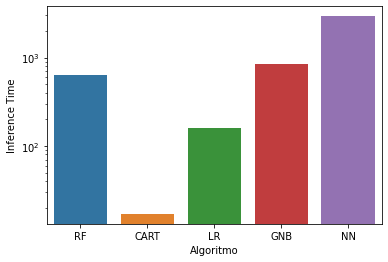

In [146]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

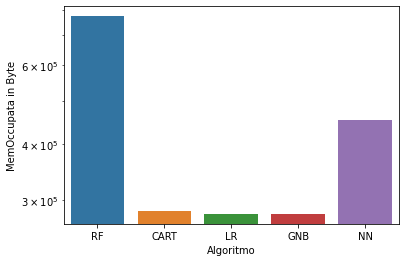

In [147]:
csv = read_csv("MemOccupationReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
g.set_yscale('log')
plt.ylabel("MemOccupata in Byte")
plt.show()
# SVC in overflow